In [71]:
#%%writefile kaggle_cnn_practice.py

In [70]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical

%matplotlib inline

In [4]:
np.random.seed(2)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

In [6]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [7]:
sns.set(style='white', context='notebook', palette='deep')

## load data

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

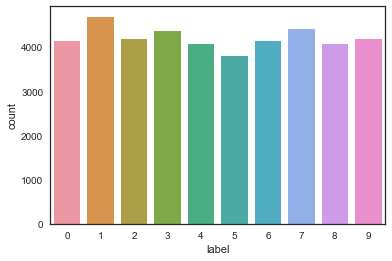

In [226]:
#load data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

Y_train = train["label"]

# drop 'label' column
X_train = train.drop(labels= ['label'], axis=1)

# free some mem.
del train

g = sns.countplot(Y_train)
Y_train.value_counts()

## check for null and missing values

In [227]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [228]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## Normalization & Reshape & Label encoding & Split training data and validation data

In [229]:
# perform a grasyscale normalization to reduce the effect of illumination's different
# the CNN converg faster on [0..1] data than on [0...255]

X_train = X_train / 255.0
test = test / 255.0

# reshape
X_train = X_train.values.reshape(-1, 28, 28, 1) 
test = test.values.reshape(-1, 28, 28, 1)

In [230]:
# label encodeing
# encode {0,1,2,3,4...} to {[1,0,0,0...0], [0,1,0,0...0]....}
Y_train = to_categorical(Y_train, num_classes=10)

In [231]:
# spilt data
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

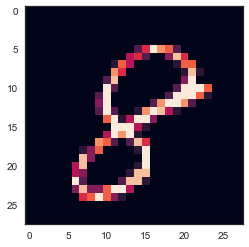

In [232]:
plt.imshow(X_train[0][:,:,0])

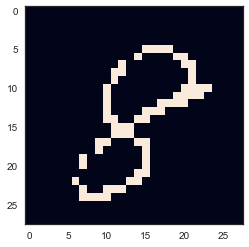

In [233]:
# test
t = X_train[0][:,:,0].copy()
t[t<=125/255.0]=0
t[t>125/255.0]=1
plt.imshow(t)
del t

## Define the model: add layers into CNN

In [62]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same',
                activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same',
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same',
                activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same',
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [64]:
# define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
# set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.0001)

In [66]:
epochs = 1 # turn epoches to 30 to get 0.9967 accuracy
batch_size = 86

## Data augmentation (to imporve the accuracy)

In [67]:
# without data augmentation
history = model.fit(X_train, Y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_val, Y_val), verbose=2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/1
 - 140s - loss: 0.2376 - acc: 0.9239 - val_loss: 0.0678 - val_acc: 0.9790


In [76]:
# with data augmentation
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=10,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=False,
                            vertical_flip=False)

datagen.fit(X_train)

In [ ]:
# very slow.
#history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
#                              epochs=epochs, validation_data=(X_val, Y_val),
#                              verbose=2, steps_per_epoch=X_train.shape[0],
#                              callbacks=[learning_rate_reduction])

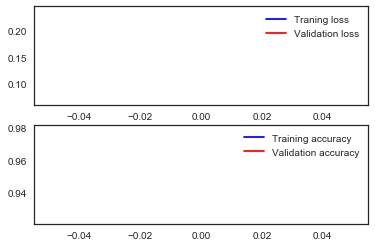

In [83]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Traning loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation accuracy')
legend = ax[1].legend(loc='best', shadow=True)

In [86]:
history.history

{'val_loss': [0.06781298663311948],
 'val_acc': [0.9790476102772213],
 'loss': [0.23756455382553948],
 'acc': [0.9239417925187283]}

In [136]:
def plot_confusion_martix(cm, classes,
                         normalize=False,
                         title='Confusion martrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_mark = np.arange(len(classes))
    plt.xticks(tick_mark, classes, rotation=45)
    plt.yticks(tick_mark, classes)
    
    if (normalize):
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
Y_pred = model.predict(X_val)

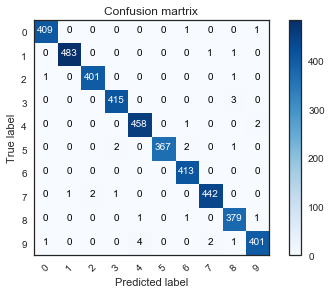

In [137]:
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
# compute the confusion martix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_martix(confusion_mtx, classes=range(10))

## Investigate for errors.

In [138]:
errors = (Y_pred_classes - Y_true !=0)

In [144]:
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

In [219]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(5,4))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((28,28)))
            ax[row, col].set_title('Predicted label: {}\nTrue label: {}'.format(pred_errors[error], obs_errors[error]))
            n+=1

In [149]:
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

In [152]:
Y_pred_errors_prob

array([0.7152533 , 0.5521195 , 0.6886297 , 0.94161934, 0.9964329 ,
       0.7181942 , 0.5441626 , 0.88106996, 0.9992563 , 0.6324141 ,
       0.5923027 , 0.6151543 , 0.6109494 , 0.47368795, 0.49622428,
       0.9832487 , 0.76417154, 0.98694104, 0.9959967 , 0.59037334,
       0.76916325, 0.7120638 , 0.99999833, 0.9999031 , 0.81182814,
       0.865816  , 0.76907533, 0.95074797, 0.9996437 , 0.7633326 ,
       0.8375353 , 0.9852498 ], dtype=float32)

In [156]:
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

In [159]:
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

In [161]:
sorted_dala_errors = np.argsort(delta_pred_true_errors)

In [163]:
delta_pred_true_errors[sorted_dala_errors]

array([0.00644371, 0.02692145, 0.09102961, 0.17115313, 0.1979267 ,
       0.2222026 , 0.2653845 , 0.3772793 , 0.42444956, 0.47278357,
       0.5064225 , 0.52666813, 0.5290092 , 0.53922045, 0.5639804 ,
       0.5977922 , 0.6900578 , 0.7319229 , 0.7457791 , 0.7675783 ,
       0.8602108 , 0.9369863 , 0.9389287 , 0.97279716, 0.97395414,
       0.9786193 , 0.9922282 , 0.9929056 , 0.99859536, 0.9992874 ,
       0.99985486, 0.9999967 ], dtype=float32)

In [164]:
most_important_errors = sorted_dala_errors[-6:]

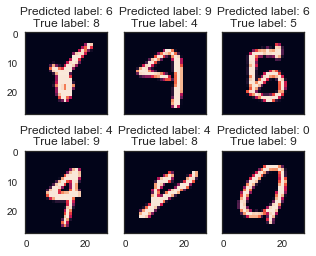

In [220]:
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

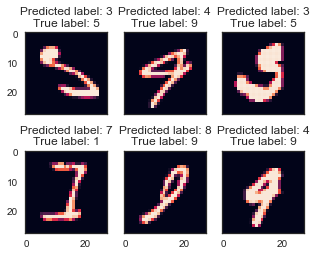

In [221]:
display_errors(sorted_dala_errors[6:], X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [235]:
test = pd.read_csv('./test.csv')
test = test / 255.0
test = test.values.reshape(-1, 28, 28, 1)
results = model.predict(test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name='Label')

In [236]:
submission = pd.concat([pd.Series(range(1,28001), name="ImageId"), results], axis=1)

In [237]:
submission.to_csv('cnn_mnist_datagen.csv', index=False)